# Набор данных IMDB с 50 тыс. отзывов о фильмах на английском языке - Бинарная классификация. Логистическая регрессия

Набор данных IMDB, содержащий 50 тысяч отзывов о фильмах на английском языке для обработки естественного языка или анализа текста.

Это набор данных для бинарной классификации настроений, содержащий значительно больше данных, чем предыдущие наборы эталонных данных. Мы предоставляем набор из 50 000 крайне полярных отзывов о фильмах для обучения и тестирования моделей. Итак, спрогнозируйте количество положительных и отрицательных отзывов, используя классификацию.

Предсказание тональности отзывов о фильмах может быть полезным для компаний в развлекательной и киноиндустрии для анализа общественного мнения о своих продуктах, понимания потребностей аудитории и улучшения качества контента. Это также может помочь в разработке маркетинговых стратегий и прогнозировании популярности будущих проектов.

## О наборе данных

| Признак на английском | Перевод на русский |
|---|---|
| review | отзыв о фильме (на английском языке)|

**Target variable (целевая переменная): sentiment - positive or negative (тональность отзыва - позитивная или негативная)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load the Dataset

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/IMDB Dataset.csv')
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


# Exploratory Data Analysis (EDA)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


В наборе данных пропусков нет

In [ ]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
data.describe(include="object")

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


Видим, что в наборе данных имеются дубликаты - удалим их

In [ ]:
data = data.drop_duplicates()
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
data.describe()

,review,sentiment
count,49582,49582
unique,49582,2
top,One of the other reviewers has mentioned that ...,positive
freq,1,24884


In [ ]:
data.describe(include="object")

,review,sentiment
count,49582,49582
unique,49582,2
top,One of the other reviewers has mentioned that ...,positive
freq,1,24884


Теперь в наборе данных все объекты уникальные

In [ ]:
data["sentiment"].nunique()

2

Количество уникальных меток классов действительно 2 (позитивный или негативный отзыв)

In [ ]:
data.columns

Index(['review', 'sentiment'], dtype='object')

<Axes: >

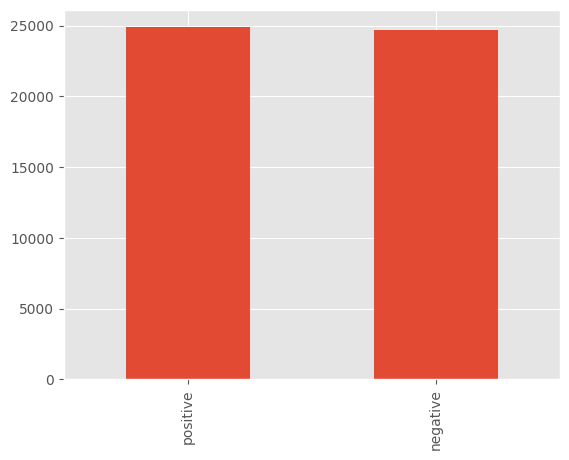

In [ ]:
data.sentiment.value_counts().plot(kind = 'bar')

In [ ]:
positive_count = (data['sentiment'] == 'positive').sum()
negative_count = (data['sentiment'] == 'negative').sum()

positive_count, negative_count

(24884, 24698)

Видим, что классы целевой переменной практически сбалансированные

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49582 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


 # Data preprocessing

## Лемматизация текста

In [ ]:
# Инициализация лемматизатора
lemmatizer = WordNetLemmatizer()

# Функция для лемматизации текста
def lemmatize_text(text):
    tokens = word_tokenize(text)  # Токенизация текста
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Лемматизация токенов
    return ' '.join(lemmatized_tokens)

# Применение лемматизации к столбцу 'review'
data['review_lemmatized'] = data['review'].apply(lemmatize_text)

<ipython-input-16-66ff9cc14f3c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['review_lemmatized'] = data['review'].apply(lemmatize_text)


In [ ]:
data

,review,sentiment,review_lemmatized
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewer ha mentioned that af...
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production . < br / > < br ...
2,I thought this was a wonderful way to spend ti...,positive,I thought this wa a wonderful way to spend tim...
3,Basically there's a family where a little boy ...,negative,Basically there 's a family where a little boy...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,Petter Mattei 's `` Love in the Time of Money ...
...,...,...,...
49995,I thought this movie did a down right good job...,positive,I thought this movie did a down right good job...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,"Bad plot , bad dialogue , bad acting , idiotic..."
49997,I am a Catholic taught in parochial elementary...,negative,I am a Catholic taught in parochial elementary...
49998,I'm going to have to disagree with the previou...,negative,I 'm going to have to disagree with the previo...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49582 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   review             49582 non-null  object
 1   sentiment          49582 non-null  object
 2   review_lemmatized  49582 non-null  object
dtypes: object(3)
memory usage: 1.5+ MB


In [ ]:
data.describe()

,review,sentiment,review_lemmatized
count,49582,49582,49582
unique,49582,2,49580
top,One of the other reviewers has mentioned that ...,positive,How Tasty Was My Little Frenchman tell a story...
freq,1,24884,2


## Токенизация и векторизация текста с использованием мешка слов

In [ ]:
# Создание мешка слов на основе лемматизированных текстов
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['review_lemmatized'])
# Приведение меток классов к числовому формату
y = [1 if sentiment == "positive" else 0 for sentiment in data['sentiment']]

In [ ]:
X,y

(<49582x97300 sparse matrix of type '<class 'numpy.int64'>'
 	with 6634025 stored elements in Compressed Sparse Row format>,
 [1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,


# Model Train and Predict

## Библиотека функций

### Функция для подсчета метрик качества модели бинарной классификации

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

def calculate_classification_metrics(y_true, y_pred,  y_pred_proba, model_name):
    """
    Функция для подсчета метрик качества модели бинарной классификации.

    Аргументы:
    y_true -- истинные значения целевой переменной
    y_pred -- предсказанные значения целевой переменной
    y_pred_proba -- вероятности предсказаний (для бинарной классификации)
    model_name -- название модели

    Возвращает словарь с названиями метрик и их значениями.
    """
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_pred_proba[:,1]),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'Confusion Matrix': confusion_matrix(y_true, y_pred).tolist()
    }

    return metrics

### Модель логистической регрессии №1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
pol_model = LogisticRegression()
pol_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
pol_model.coef_, pol_model.intercept_

(array([[-0.04838134,  0.00069731, -0.0021675 , ..., -0.0012354 ,
         -0.02066807, -0.02066807]]),
 array([-0.03541709]))

In [ ]:
pol_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
res_1 = pol_model.predict(X_test)

In [ ]:
y_pred_proba = pol_model.predict_proba(X_test)

In [ ]:
metrics_1 = calculate_classification_metrics(y_test, res_1, y_pred_proba, 'Model Logistic Regression №1')
print("Метрики качества модели:")
for metric, value in metrics_1.items():
    print(f"{metric}: {value}")

Метрики качества модели:
Model: Model Logistic Regression №1
Accuracy: 0.8870626197438741
ROC AUC: 0.9486733732085887
Precision: 0.8821315372424723
Recall: 0.8945359582161511
F1 Score: 0.8882904448434072
Confusion Matrix: [[4344, 595], [525, 4453]]


In [ ]:
print(classification_report(y_test, res_1))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      4939
           1       0.88      0.89      0.89      4978

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



# **Confusion matrix - Матрица ошибок** <a class="anchor" id="15"></a>

Матрица ошибок — это инструмент для обобщения производительности алгоритма классификации. Она дает нам четкое представление о производительности модели классификации и типах ошибок, производимых моделью, в виде сводки правильных и неправильных прогнозов с разбивкой по каждой категории.

При оценке эффективности модели классификации возможны четыре типа результатов:


**Истинные положительные результаты (TP)**. Истинные положительные результаты возникают, когда мы предсказываем, что наблюдение принадлежит к определенному классу, и наблюдение действительно принадлежит к этому классу.


**Истинно отрицательные результаты (TN)** — истинно отрицательные результаты возникают, когда мы предсказываем, что наблюдение не принадлежит к определенному классу, и наблюдение фактически не принадлежит к этому классу.


**Ложные срабатывания (FP)**. Ложные срабатывания возникают, когда мы предсказываем, что наблюдение относится к определенному классу, но на самом деле наблюдение не принадлежит к этому классу. Этот тип ошибки называется **ошибкой типа I.**



**Ложноотрицательные результаты (FN)**. Ложноотрицательные результаты возникают, когда мы предсказываем, что наблюдение не принадлежит к определенному классу, но на самом деле оно принадлежит этому классу. Это очень серьезная ошибка, и она называется **ошибкой типа II**.



In [ ]:
from sklearn.metrics import confusion_matrix
lr_confusion_matrix = confusion_matrix(y_test, res_1)
lr_confusion_matrix1 = pd.DataFrame(lr_confusion_matrix)

lr_confusion_matrix1

,0,1
0,4344,595
1,525,4453


In [ ]:
print('\nTrue Positives(TP) = ', lr_confusion_matrix[0,0])

print('\nTrue Negatives(TN) = ', lr_confusion_matrix[1,1])

print('\nFalse Positives(FP) = ', lr_confusion_matrix[0,1])

print('\nFalse Negatives(FN) = ', lr_confusion_matrix[1,0])


True Positives(TP) =  4344

True Negatives(TN) =  4453

False Positives(FP) =  595

False Negatives(FN) =  525


<Axes: >

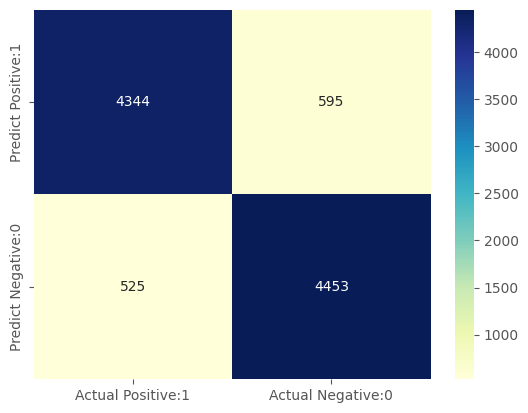

In [ ]:
cm_matrix = pd.DataFrame(data=lr_confusion_matrix, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

### Модель логистической регрессии №2

In [ ]:
from sklearn.utils import shuffle

In [ ]:
# перемешиваем данные
X, y = shuffle(X, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
pol_model = LogisticRegression()
pol_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
res_2 = pol_model.predict(X_test)

In [ ]:
y_pred_proba = pol_model.predict_proba(X_test)

In [ ]:
metrics_2 = calculate_classification_metrics(y_test, res_2, y_pred_proba, 'Model Logistic Regression №2')
print("Метрики качества модели:")
for metric, value in metrics_2.items():
    print(f"{metric}: {value}")

Метрики качества модели:
Model: Model Logistic Regression №2
Accuracy: 0.8862559241706162
ROC AUC: 0.9522032003363158
Precision: 0.8804629814408301
Recall: 0.892936652499494
F1 Score: 0.8866559485530547
Confusion Matrix: [[4377, 599], [529, 4412]]


In [ ]:
print(classification_report(y_test, res_2))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      4976
           1       0.88      0.89      0.89      4941

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



<Axes: >

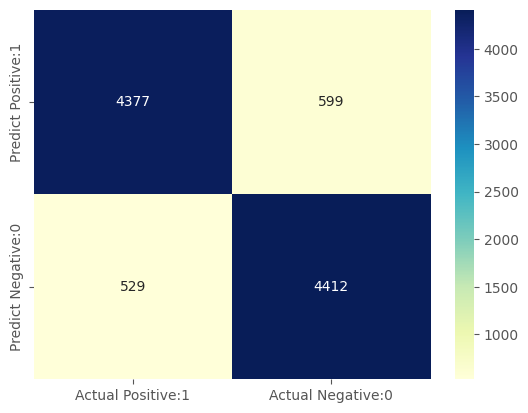

In [ ]:
lr_confusion_matrix = confusion_matrix(y_test, res_2)


cm_matrix = pd.DataFrame(data=lr_confusion_matrix, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

### Модель логистической регрессии №3
Построим 2 варианта моделей с нормализацией данных

In [ ]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()

In [ ]:
norm_features = scaler.fit_transform(X)

In [ ]:
#Первая строкя нормализованных признаков в разреженной матрице формата CSR
from scipy.sparse import csr_matrix

sparse_norm_features = csr_matrix(norm_features)
print(sparse_norm_features[0])

  (0, 56)	0.05263157894736842
  (0, 506)	0.058823529411764705
  (0, 1853)	0.13333333333333333
  (0, 1966)	0.4
  (0, 2291)	0.125
  (0, 2341)	0.14285714285714285
  (0, 2415)	0.14285714285714285
  (0, 2936)	0.125
  (0, 3635)	0.07142857142857142
  (0, 3855)	0.06666666666666667
  (0, 3941)	0.125
  (0, 4027)	0.1111111111111111
  (0, 4305)	0.047619047619047616
  (0, 4428)	0.09183673469387754
  (0, 5014)	0.25
  (0, 5208)	0.16666666666666666
  (0, 5545)	0.041666666666666664
  (0, 5685)	0.42857142857142855
  (0, 6523)	0.2857142857142857
  (0, 6625)	0.125
  (0, 6637)	0.25
  (0, 7004)	0.16666666666666666
  (0, 7265)	0.15384615384615385
  (0, 7739)	0.08333333333333333
  (0, 8627)	0.07692307692307693
  :	:
  (0, 87087)	0.2
  (0, 87804)	0.3333333333333333
  (0, 88207)	0.5
  (0, 88681)	0.1111111111111111
  (0, 91219)	0.034482758620689655
  (0, 91976)	0.3333333333333333
  (0, 92041)	0.3333333333333333
  (0, 92296)	0.07142857142857142
  (0, 93222)	0.11428571428571428
  (0, 93545)	0.1111111111111111
  (0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(norm_features, y, test_size=0.2)

In [ ]:
pol_model = LogisticRegression()
pol_model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
res_3 = pol_model.predict(X_test)

In [ ]:
y_pred_proba = pol_model.predict_proba(X_test)

In [ ]:
metrics_3 = calculate_classification_metrics(y_test, res_3, y_pred_proba, 'Model Logistic Regression №3')
print("Метрики качества модели:")
for metric, value in metrics_3.items():
    print(f"{metric}: {value}")

Метрики качества модели:
Model: Model Logistic Regression №3
Accuracy: 0.893717858223253
ROC AUC: 0.956466280807043
Precision: 0.8952837729816147
Recall: 0.8942115768463074
F1 Score: 0.8947473537048132
Confusion Matrix: [[4383, 524], [530, 4480]]


In [ ]:
print(classification_report(y_test, res_3))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      4907
           1       0.90      0.89      0.89      5010

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



<Axes: >

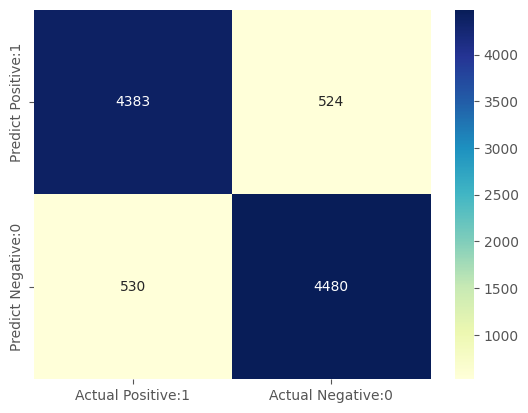

In [ ]:
lr_confusion_matrix = confusion_matrix(y_test, res_3)


cm_matrix = pd.DataFrame(data=lr_confusion_matrix, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

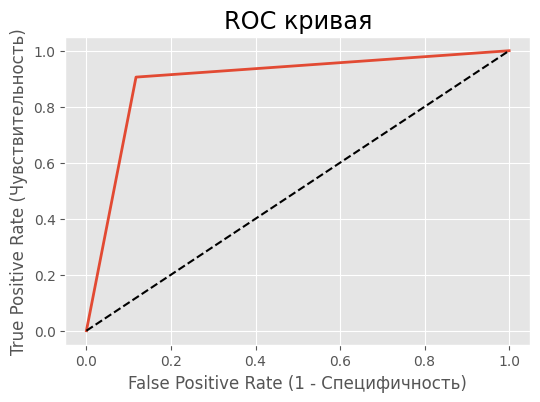

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, res_3, pos_label = 1)

plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12

plt.title('ROC кривая')

plt.xlabel('False Positive Rate (1 - Специфичность)')

plt.ylabel('True Positive Rate (Чувствительность)')

plt.show()

### Модель логистической регрессии №4

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
norm_features_train = scaler.fit_transform(X_train)
norm_features_test = scaler.fit_transform(X_test)

In [ ]:
pol_model = LogisticRegression()
pol_model.fit(norm_features_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
res_4 = pol_model.predict(norm_features_test)

In [ ]:
y_pred_proba = pol_model.predict_proba(norm_features_test)

In [ ]:
metrics_4 = calculate_classification_metrics(y_test, res_4, y_pred_proba, 'Model Logistic Regression №4')
print("Метрики качества модели:")
for metric, value in metrics_4.items():
    print(f"{metric}: {value}")

Метрики качества модели:
Model: Model Logistic Regression №4
Accuracy: 0.889381869516991
ROC AUC: 0.9536359254792782
Precision: 0.8930689020650174
Recall: 0.8838526912181303
F1 Score: 0.8884368961659717
Confusion Matrix: [[4452, 523], [574, 4368]]


In [ ]:
print(classification_report(y_test, res_4))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      4975
           1       0.89      0.88      0.89      4942

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



<Axes: >

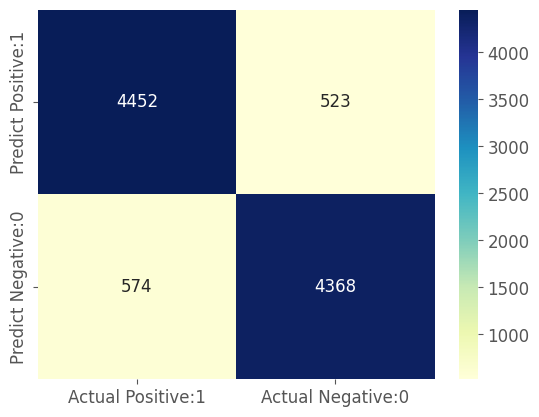

In [ ]:
lr_confusion_matrix = confusion_matrix(y_test, res_4)


cm_matrix = pd.DataFrame(data=lr_confusion_matrix, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

### Модель логистической регрессии №5 (с автоматическим подбором гиперпараметров модели)
Изменим базовые параметры модели

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
norm_features = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(norm_features, y, test_size=0.2)

In [ ]:
parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']},
              {'C':[0.001, 0.01, 0.1, 1, 10, 100]}]

lr = LogisticRegression(max_iter=100)

grid_search = GridSearchCV(estimator = lr,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)


grid_search.fit(X_train, y_train)
grid_search.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef

{'solver': 'saga'}

In [ ]:
grid_search.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(),
 'n_jobs': None,
 'param_grid': [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
  {'penalty': ['none', 'elasticnet', 'l1', 'l2']},
  {'C': [0.001, 0.01, 0.1, 1, 10, 100]}],
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': 'accuracy',
 'verbose': 0}

In [ ]:
res_5 = grid_search.predict(X_test)

In [ ]:
y_pred_proba = pol_model.predict_proba(X_test)

In [ ]:
metrics_5 = calculate_classification_metrics(y_test, res_5, y_pred_proba, 'Model Logistic Regression №5')
print("Метрики качества модели:")
for metric, value in metrics_5.items():
    print(f"{metric}: {value}")

Метрики качества модели:
Model: Model Logistic Regression №5
Accuracy: 0.892507814863366
ROC AUC: 0.9901416488988336
Precision: 0.8868634832573806
Recall: 0.9004224502112251
F1 Score: 0.8935915352365742
Confusion Matrix: [[4375, 571], [495, 4476]]


In [ ]:
print(classification_report (y_test, res_5))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4946
           1       0.89      0.90      0.89      4971

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



<Axes: >

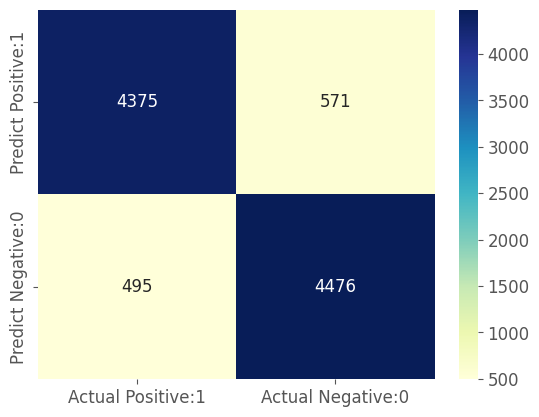

In [ ]:
lr_confusion_matrix = confusion_matrix(y_test, res_5)


cm_matrix = pd.DataFrame(data=lr_confusion_matrix, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

### Модель логистической регрессии №6

In [ ]:
norm_features = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(norm_features, y, test_size=0.2)

In [ ]:
pol_model = LogisticRegression(solver = 'saga')
pol_model.fit(X_train, y_train)

LogisticRegression(solver='saga')

In [ ]:
res_6 = pol_model.predict(X_test)

In [ ]:
y_pred_proba = pol_model.predict_proba(X_test)

In [ ]:
metrics_6 = calculate_classification_metrics(y_test, res_6, y_pred_proba, 'Model Logistic Regression №6')
print("Метрики качества модели:")
for metric, value in metrics_6.items():
    print(f"{metric}: {value}")

Метрики качества модели:
Model: Model Logistic Regression №6
Accuracy: 0.8928103257033377
ROC AUC: 0.959318897714663
Precision: 0.8842105263157894
Recall: 0.9062937062937063
F1 Score: 0.8951159348791318
Confusion Matrix: [[4318, 594], [469, 4536]]


In [ ]:
print(classification_report(y_test, res_6))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4912
           1       0.88      0.91      0.90      5005

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



<Axes: >

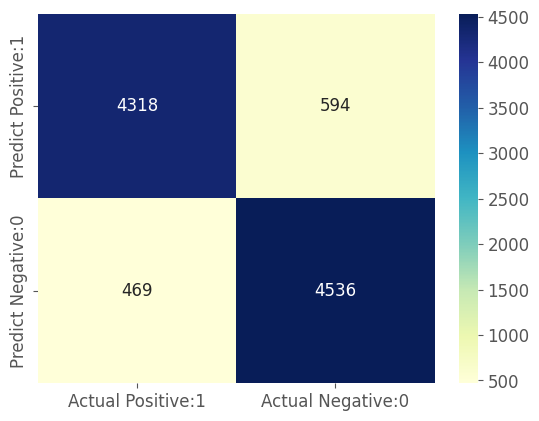

In [ ]:
lr_confusion_matrix = confusion_matrix(y_test, res_6)


cm_matrix = pd.DataFrame(data=lr_confusion_matrix, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

### Модель логистической регрессии №7 с применением TF-IDF подхода к токенизации и векторизации текста

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Инициализация TfidfVectorizer с указанием стоп-слов
tfidf_vec = TfidfVectorizer(stop_words='english')

# Преобразование текстов в TF-IDF признаки
X = tfidf_vec.fit_transform(data['review_lemmatized'])

# Приведение меток классов к числовому формату
y = [1 if sentiment == "positive" else 0 for sentiment in data['sentiment']]

In [ ]:
X,y

(<49582x96989 sparse matrix of type '<class 'numpy.float64'>'
 	with 4318795 stored elements in Compressed Sparse Row format>,
 [1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0

In [ ]:
# перемешиваем данные
X, y = shuffle(X, y)

In [ ]:
norm_features = scaler.fit_transform(X)

In [ ]:
#Первая строкя нормализованных признаков в разреженной матрице формата CSR
from scipy.sparse import csr_matrix

sparse_norm_features = csr_matrix(norm_features)
print(sparse_norm_features[0])

  (0, 22325)	1.0
  (0, 56581)	0.9266464794979836
  (0, 67490)	1.0
  (0, 61338)	0.9999999999999999
  (0, 6323)	0.6658361860564275
  (0, 75063)	0.4158140731586426
  (0, 51198)	0.4394257203045083
  (0, 68252)	0.4273618521932495
  (0, 20052)	0.2695523747023397
  (0, 72432)	0.37473848146800365
  (0, 15467)	0.2537218085080359
  (0, 70937)	0.6479376688225723
  (0, 32476)	0.47036637891556204
  (0, 81241)	0.45766395562965
  (0, 18021)	0.3750805935956875
  (0, 13997)	0.15376186814821535
  (0, 13019)	0.27691768011972623
  (0, 42757)	0.4492678617795063
  (0, 71141)	0.24413618777758886
  (0, 60250)	0.2969394314585277
  (0, 15041)	0.29112894033291925
  (0, 29840)	0.25519566198829446
  (0, 83558)	0.43368921155056317
  (0, 32975)	0.5447542779491439
  (0, 29038)	0.27150687055384215
  (0, 75586)	0.3087577272130291
  (0, 80021)	0.35048288893052293
  (0, 18797)	0.3700783290802965
  (0, 15663)	0.3029372331969665
  (0, 9431)	0.1676539576179347
  (0, 12591)	0.34660046066327294
  (0, 36261)	0.4202075329335688

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(norm_features, y, test_size=0.2)

In [ ]:
pol_model = LogisticRegression()
pol_model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
res_7 = pol_model.predict(X_test)

In [ ]:
y_pred_proba = pol_model.predict_proba(X_test)

In [ ]:
metrics_7 = calculate_classification_metrics(y_test, res_7, y_pred_proba, 'Model Logistic Regression №7')
print("Метрики качества модели:")
for metric, value in metrics_7.items():
    print(f"{metric}: {value}")

Метрики качества модели:
Model: Model Logistic Regression №7
Accuracy: 0.8878693153171322
ROC AUC: 0.9563014265830743
Precision: 0.8826318909306461
Recall: 0.8960882647943832
F1 Score: 0.8893091777822019
Confusion Matrix: [[4338, 594], [518, 4467]]


In [ ]:
print(classification_report(y_test, res_7))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      4932
           1       0.88      0.90      0.89      4985

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



<Axes: >

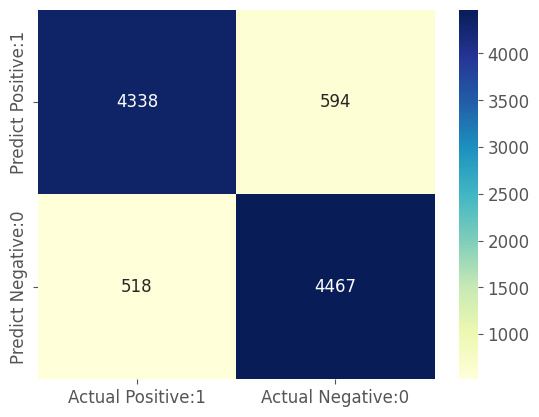

In [ ]:
lr_confusion_matrix = confusion_matrix(y_test, res_7)


cm_matrix = pd.DataFrame(data=lr_confusion_matrix, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

# Model Evaluation

In [ ]:
model_metrics_1_filtered = {key: value for key, value in metrics_1.items() if ((key != 'Model') and (key != 'Confusion Matrix'))}

model_metrics_2_filtered = {key: value for key, value in metrics_2.items() if ((key != 'Model') and (key != 'Confusion Matrix'))}

model_metrics_3_filtered = {key: value for key, value in metrics_3.items() if ((key != 'Model') and (key != 'Confusion Matrix'))}

model_metrics_4_filtered = {key: value for key, value in metrics_4.items() if ((key != 'Model') and (key != 'Confusion Matrix'))}

model_metrics_5_filtered = {key: value for key, value in metrics_5.items() if ((key != 'Model') and (key != 'Confusion Matrix'))}

model_metrics_6_filtered = {key: value for key, value in metrics_6.items() if ((key != 'Model') and (key != 'Confusion Matrix'))}

model_metrics_7_filtered = {key: value for key, value in metrics_7.items() if ((key != 'Model') and (key != 'Confusion Matrix'))}

# Создание DataFrame
df = pd.DataFrame({
    "Model №1": model_metrics_1_filtered,
    "Model №2": model_metrics_2_filtered,
    "Model №3": model_metrics_3_filtered,
    "Model №4": model_metrics_4_filtered,
    "Model №5": model_metrics_5_filtered,
    "Model №6": model_metrics_6_filtered,
    "Model №7": model_metrics_7_filtered
})

# Функция для форматирования значений
def format_values(value):
    if isinstance(value, float):
        return "{:.8f}".format(value)
    else:
        return value

# Применение функции к каждому элементу DataFrame
df = df.applymap(format_values)

# Вывод DataFrame как красивой таблицы
display(df)

,Model №1,Model №2,Model №3,Model №4,Model №5,Model №6,Model №7
Accuracy,0.88706262,0.88131491,0.89412121,0.88938187,0.89250781,0.89281033,0.88786932
ROC AUC,0.94867337,0.94927744,0.95533076,0.95363593,0.99014165,0.95931890,0.95630143
Precision,0.88213154,0.87800995,0.88386841,0.89306890,0.88686348,0.88421053,0.88263189
Recall,0.89453596,0.88665595,0.90576767,0.88385269,0.90042245,0.90629371,0.89608826
F1 Score,0.88829044,0.88231177,0.89468405,0.88843690,0.89359154,0.89511593,0.88930918


## Вывод: лучшей моделью по метрикам качества оказалась модель логистической регрессии №3 с перемешиванием объектов в датасете, нормализацией всего объект-признакового пространства X, использованием гиперпараметров модели по умолчанию и с применением мешка слов для токенизации и векторизации текста